In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy import stats

import html
import urllib

#from helper_functions import *

In [2]:
data_path = './data/wikispeedia_paths-and-graph/'

In [3]:
def read_tsv(file_name, names=None):
    
    file_path = data_path + f'{file_name}.tsv'
    
    if not names:
        with open(file_path, 'r') as file:
            for line in file:
                if 'FORMAT' in line:
                    format_line = line
                    break

        names = format_line.split()[2:]
    
    return pd.read_csv(file_path,
                           delimiter='\t', comment='#', header=0, names=names)

In [4]:
link_network = read_tsv('links', names=['source', 'target'])
categories = read_tsv('categories')
finished_paths = read_tsv('paths_finished')
unfinished_paths = read_tsv('paths_unfinished')
articles = read_tsv('articles')

In [5]:
categories[['category_1', 'category_2', 'category_3']] = \
                                categories['category'].str.replace(
                                    'subject.', '', n=1).str.split('.', expand=True)

First research question: Do the existing categories in this abridged Wikipedia reflect optimal shortest paths and/or the path effectively taken by players?

In [6]:
# create a directed graph

G_link = nx.from_pandas_edgelist(link_network, 'source', 'target', create_using=nx.DiGraph())


In [7]:
overall_nodes = G_link.number_of_nodes()
overall_edges = G_link.number_of_edges()

overall_strong_connect = nx.is_strongly_connected(G_link)
overall_weak_connect = nx.is_weakly_connected(G_link)

print(f"Number of nodes: {overall_nodes}")
print(f"Number of edges: {overall_edges}")

# reachable from any node to any node
print(f"Strongly connected? {'Yes' if overall_strong_connect else 'No'}")
# all nodes connected regardless of direction
print(f"Weakly connected? {'Yes' if overall_weak_connect else 'No'}") 

# degree Distribution
degrees = [G_link.degree(n) for n in G_link.nodes()]
overall_avg_deg = sum(degrees) / len(degrees)
print(f"Average degree: {overall_avg_deg}")


# clustering coefficient
overall_density = nx.density(G_link)
overall_avg_cc = nx.average_clustering(G_link)
print(f"Graph density: {overall_density}")
print(f"Average clustering coefficient: {overall_avg_cc}")

Number of nodes: 4592
Number of edges: 119881
Strongly connected? No
Weakly connected? No
Average degree: 52.21297909407666
Graph density: 0.0056864494765929705
Average clustering coefficient: 0.19546171219782374


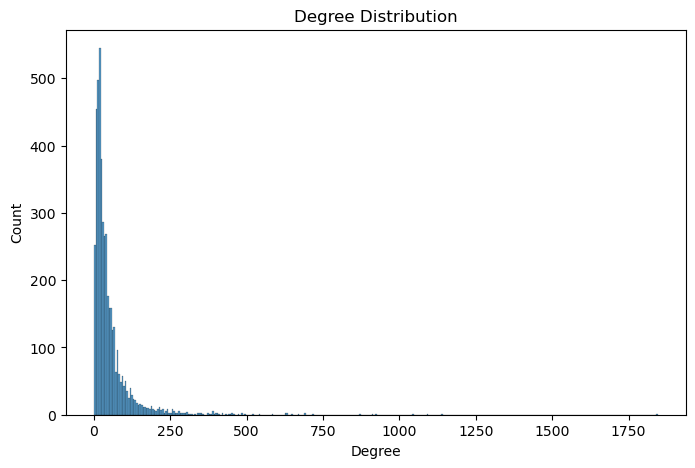

In [8]:
degrees = [G_link.degree(n) for n in G_link.nodes()]
plt.figure(figsize=(8, 5))
sns.histplot(degrees)  # Adjust the number of bins as needed
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()


- Articles are not all connected to each other.
- The average clustering coefficient indicates a moderately clustered network (considering the size).

In [9]:
# Get unique categories from 'category_1'
unique_categories = categories['category_1'].unique()
category_data = pd.DataFrame(columns=['category', 'nodes', 'edges',
                                      'avg_degree', 'density', 'clustering_coefficient',
                                     'strongly_connected', 'weakly_connected'])

category_data = category_data._append({
        'category': 'Overall/Average', 
        'nodes': overall_nodes, 
        'edges': overall_edges, 
        'avg_degree': overall_avg_deg/2, 
        'density': overall_density, 
        'clustering_coefficient': overall_avg_cc,
        'strongly_connected': overall_strong_connect,
        'weakly_connected': overall_weak_connect,
}, ignore_index=True)

# Iterate over each category and perform the analysis
for category in unique_categories:
    print(f"Analysis for Category: {category}")

    # Filter articles for the current category
    category_articles = categories[categories['category_1'] == category]['article']
    filtered_links = link_network[link_network['source'].isin(category_articles) & link_network['target'].isin(category_articles)]

    # Create a sub-network for the current category
    G_category = nx.from_pandas_edgelist(filtered_links, 'source', 'target', create_using=nx.DiGraph())

    # Perform analysis on the sub-network
    num_nodes = G_category.number_of_nodes()
    num_edges = G_category.number_of_edges()
    avg_degree = sum(dict(G_category.degree()).values()) / num_nodes if num_nodes > 0 else 0
    graph_density = nx.density(G_category)
    avg_clustering_coef = nx.average_clustering(G_category)
    
    strongly_connected = nx.is_strongly_connected(G_category)
    weakly_connected = nx.is_weakly_connected(G_category)
    
    category_data = category_data._append({
        'category': category, 
        'nodes': num_nodes, 
        'edges': num_edges, 
        'avg_degree': avg_degree/2, 
        'density': graph_density, 
        'clustering_coefficient': avg_clustering_coef,
        'strongly_connected': strongly_connected,
        'weakly_connected': weakly_connected,
    }, ignore_index=True)


    # Display the results
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average degree/2: {avg_degree/2}")
    print(f"Graph density: {graph_density}")
    print(f"Average clustering coefficient: {avg_clustering_coef}")
    print(f"Strongly connected: {strongly_connected}")
    print(f"Weakly connected: {weakly_connected}")
    print("-" * 40)


Analysis for Category: People
Number of nodes: 614
Number of edges: 3073
Average degree/2: 5.004885993485342
Graph density: 0.008164577477137589
Average clustering coefficient: 0.17848048741339442
Strongly connected: False
Weakly connected: False
----------------------------------------
Analysis for Category: Countries
Number of nodes: 229
Number of edges: 5523
Average degree/2: 24.117903930131003
Graph density: 0.10578028039531143
Average clustering coefficient: 0.4483423549677819
Strongly connected: False
Weakly connected: True
----------------------------------------
Analysis for Category: Geography
Number of nodes: 1061
Number of edges: 22570
Average degree/2: 21.272384542884073
Graph density: 0.020068287304607614
Average clustering coefficient: 0.296908274402231
Strongly connected: False
Weakly connected: True
----------------------------------------
Analysis for Category: History
Number of nodes: 494
Number of edges: 3870
Average degree/2: 7.834008097165992
Graph density: 0.01589

In [10]:
# compute averages
category_data.at[0, 'nodes'] = category_data.at[0, 'nodes'] / 15
category_data.at[0, 'edges'] = category_data.at[0, 'edges'] / 15

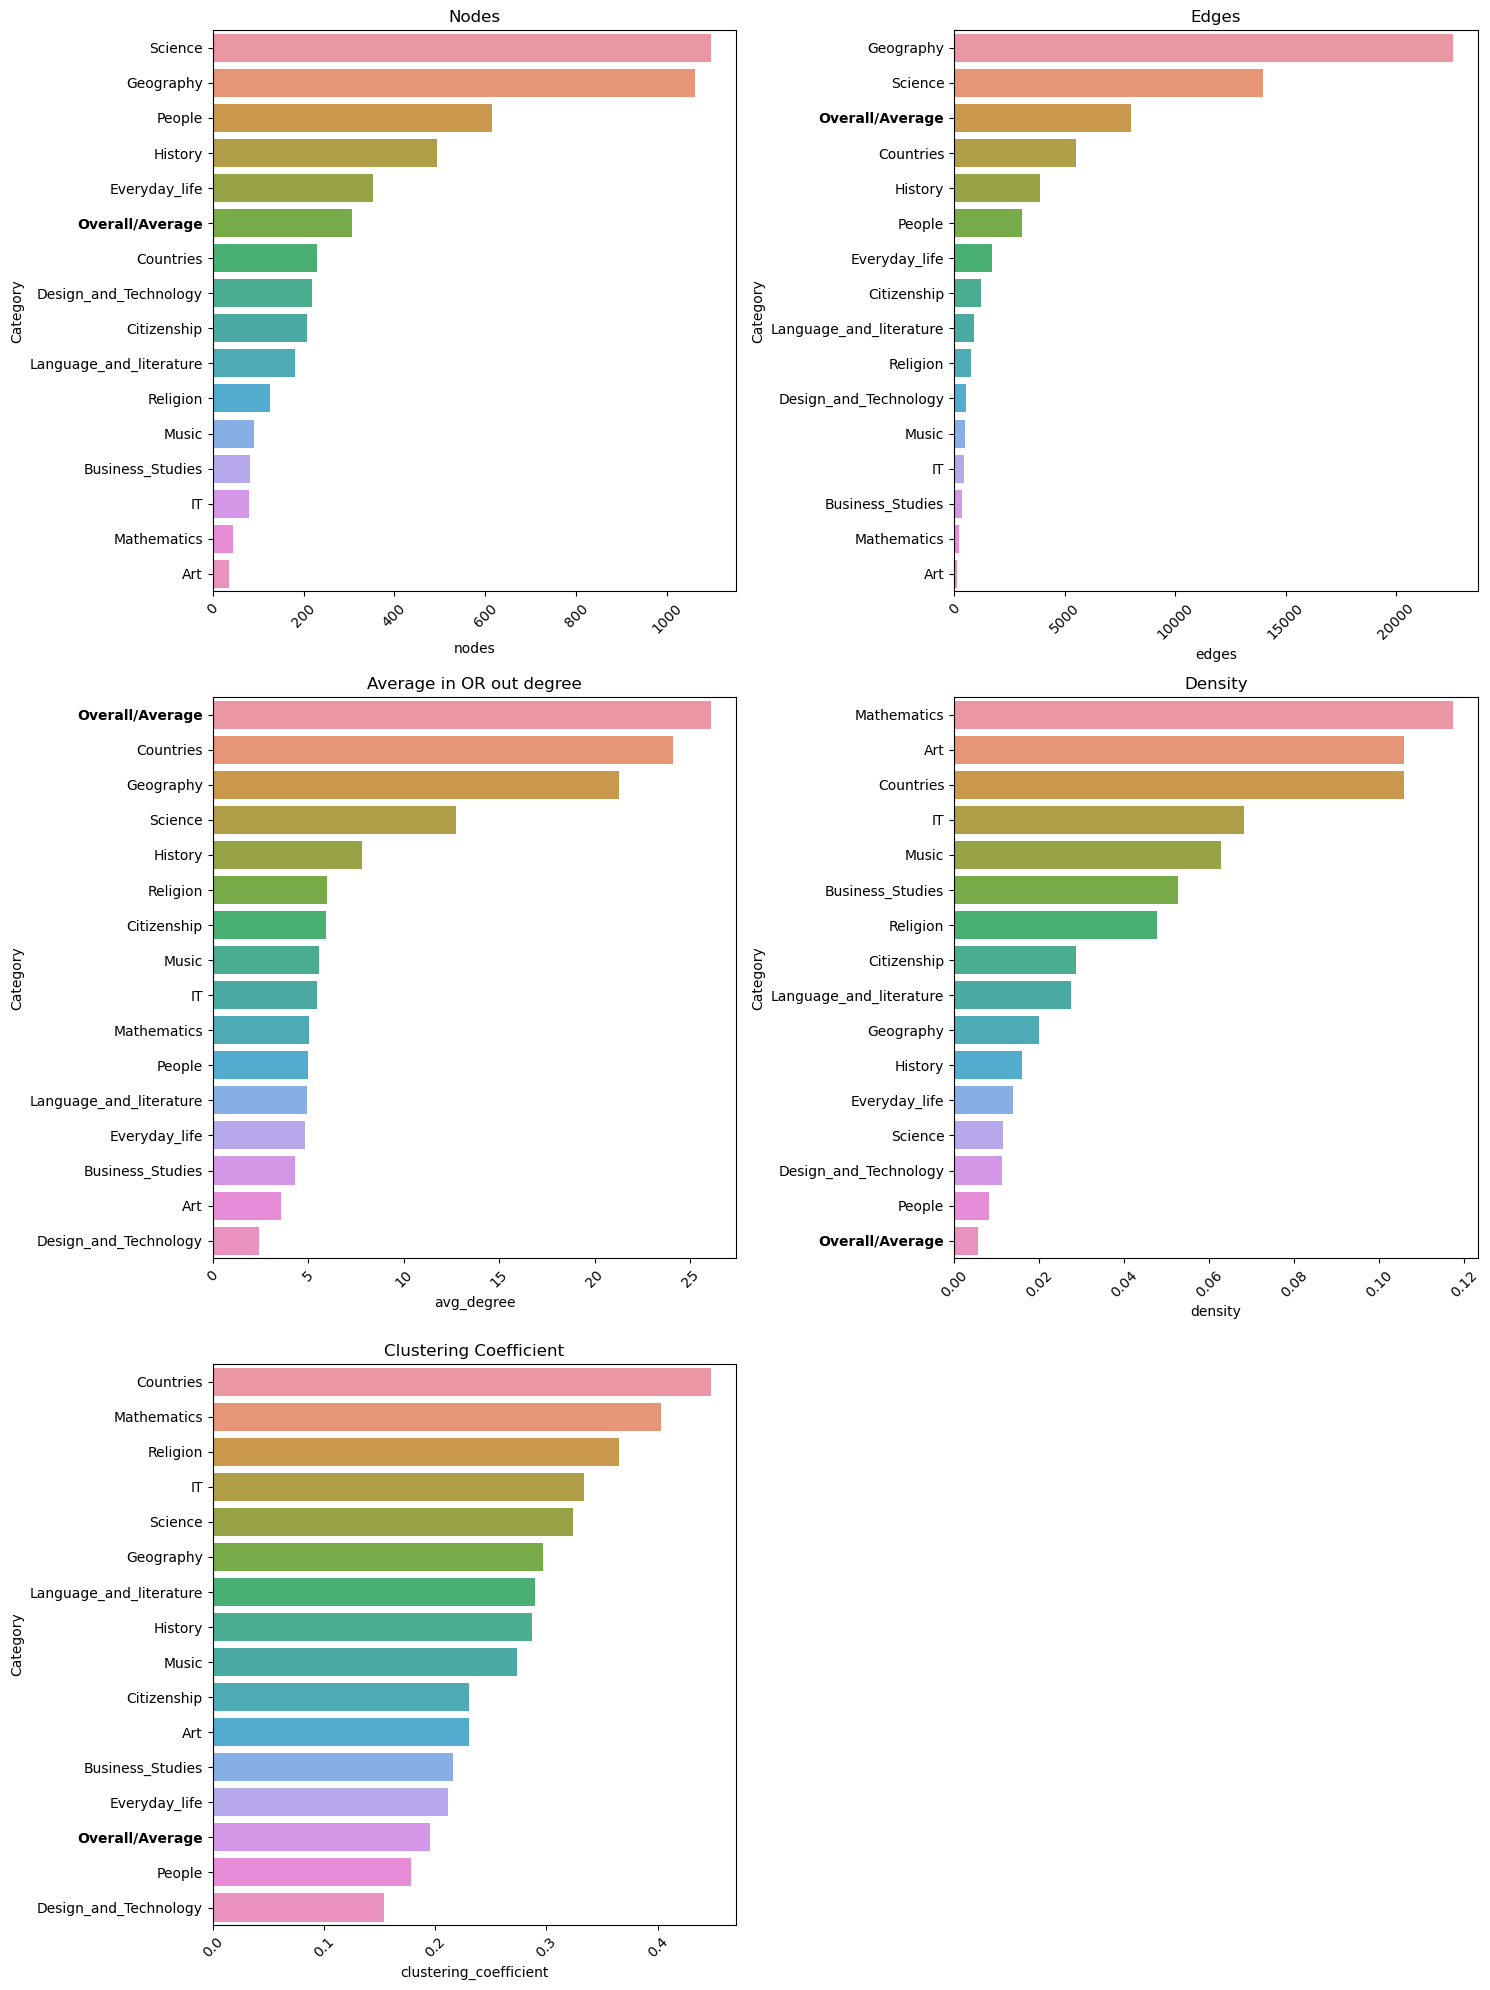

In [21]:

properties = ['nodes', 'edges', 'avg_degree', 'density', 'clustering_coefficient']

plt.figure(figsize=(15, 20))

for i, prop in enumerate(properties, 1):
    plt.subplot(3, 2, i)  
    sorted_data = category_data.sort_values(by=prop, ascending=False)
    sns.barplot(y='category', x=prop, data=sorted_data)
    for lab in plt.gca().get_yticklabels():
        if lab.get_text() == "Overall/Average":
            lab.set_fontweight('bold')
    
    title_txt = f'{prop.replace("_", " ").title()}'
    if prop == 'avg_degree': title_txt = 'Average in OR out degree'
    plt.title(title_txt)
    plt.ylabel('Category')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [26]:

category_data.loc[category_data['category'] == 'Overall/Average', 'category'] = '<b>Overall/Average</b>'


In [27]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

properties = ['nodes', 'edges', 'avg_degree', 'density', 'clustering_coefficient']

fig = make_subplots(rows=3, cols=2, subplot_titles=[prop.replace("_", " ").title() if prop != 'avg_degree' else 'Average in OR out degree' for prop in properties])

for i, prop in enumerate(properties):
    sorted_data = category_data.sort_values(by=prop, ascending=False)
    colors = ['lightgray' if category == "Overall/Average" else f'rgb({np.random.randint(0,255)}, {np.random.randint(0,255)}, {np.random.randint(0,255)})' for category in sorted_data['category']]

    fig.add_trace(
        go.Bar(
            x=sorted_data[prop], 
            y=sorted_data['category'], 
            orientation='h', 
            marker_color=colors,
            showlegend=False
        ),
        row=(i // 2) + 1, 
        col=(i % 2) + 1
    )


# Update layout
fig.update_layout(height=2000, width=800, title_text="Your Graph Title")
fig.show()


- Within each category compared to overall: much higher graph density, usually higher avg clustering coefficients
- Some categories are more connected than others, or have more links, or more dense.
- In some categories, all articles are weakly connected.

In [30]:

file_path = data_path + 'shortest-path-distance-matrix.txt'

distance_matrix = []

with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('#') or line.isspace():
            continue
        distances = [-1 if char == '_' else int(char) for char in line.strip()]
        distance_matrix.append(distances)

shortest_paths = pd.DataFrame(distance_matrix)



In [37]:
# Replace -1 and 0 with NaN
shortest_paths_replaced = shortest_paths.replace([-1, 0], None)

# Calculate the overall average shortest path length
total_distance = shortest_paths_replaced.sum().sum()
count_valid_distances = shortest_paths_replaced.count().sum()
overall_average_shortest_path = total_distance / count_valid_distances if count_valid_distances > 0 else None

print(f"Average shortest path length: {overall_average_shortest_path}")


Average shortest path length: 3.202522563331053


In [38]:

category_avg_path_lengths = {}
category_shortest_paths = {}

article_to_index = pd.Series(articles.index, index=articles['article']).to_dict()

def calculate_avg_shortest_path(filtered_shortest_paths):
    filtered_shortest_paths_replaced = filtered_shortest_paths.replace([-1, 0], np.nan)
    total_distance = np.nansum(filtered_shortest_paths_replaced.values)
    count_valid_distances = np.sum(~np.isnan(filtered_shortest_paths_replaced.values))
    return total_distance / count_valid_distances if count_valid_distances > 0 else None

for category in unique_categories:
    category_articles = categories[categories['category_1'] == category]['article']
    category_article_indices = [article_to_index[article] for article in category_articles if article in article_to_index]
    filtered_shortest_paths = shortest_paths.iloc[category_article_indices, category_article_indices]

    avg_shortest_path = calculate_avg_shortest_path(filtered_shortest_paths)
    category_avg_path_lengths[category] = avg_shortest_path

    valid_distances = filtered_shortest_paths.values[(filtered_shortest_paths != -1) & (filtered_shortest_paths != 0)]
    category_shortest_paths[category] = valid_distances

for category, avg_shortest_path in category_avg_path_lengths.items():
    print(f"Category: {category}, Average shortest path length: {avg_shortest_path}")

# Perform ANOVA using the shortest paths data
grouped_data = list(category_shortest_paths.values())
anova_result = stats.f_oneway(*grouped_data)
print(f"ANOVA F-statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}")


Category: People, Average shortest path length: 3.1603989405846993
Category: Countries, Average shortest path length: 3.144965494304482
Category: Geography, Average shortest path length: 3.2149226810807074
Category: History, Average shortest path length: 3.0724539555877968
Category: Business_Studies, Average shortest path length: 3.1384332362409935
Category: Science, Average shortest path length: 3.25707298928542
Category: Everyday_life, Average shortest path length: 3.180583118343587
Category: Design_and_Technology, Average shortest path length: 3.130738684347654
Category: Music, Average shortest path length: 3.272845643939394
Category: IT, Average shortest path length: 3.2758502232909654
Category: Language_and_literature, Average shortest path length: 3.246640497406951
Category: Mathematics, Average shortest path length: 3.291267942583732
Category: Religion, Average shortest path length: 3.0906029402240787
Category: Art, Average shortest path length: 3.0286650286650287
Category: Citi

In [39]:
pd.DataFrame(category_avg_path_lengths.items(), columns=['category', 'avg_spl']).describe()

,avg_spl
count,15.000000
mean,3.175591
std,0.081234
min,3.028665
25%,3.129579
50%,3.160399
75%,3.251857
max,3.291268


In [40]:
import plotly.graph_objs as go

category_data = pd.DataFrame({
    'Category': ['People', 'Countries', 'Geography', 'History', 'Business_Studies', 'Science', 
                 'Everyday_life', 'Design_and_Technology', 'Music', 'IT', 'Language_and_literature', 
                 'Mathematics', 'Religion', 'Art', 'Citizenship'],
    'Average Shortest Path Length': [3.1603989405846993, 3.144965494304482, 3.2149226810807074, 
                                     3.0724539555877968, 3.1384332362409935, 3.25707298928542, 3.180583118343587, 
                                     3.130738684347654, 3.272845643939394, 3.2758502232909654, 3.246640497406951, 
                                     3.291267942583732, 3.0906029402240787, 3.0286650286650287, 3.1284196299575897]
})

overall_average = 3.202522563331053

fig = go.Figure(data=[go.Bar(
    x=category_data['Category'],
    y=category_data['Average Shortest Path Length'],
    name='Average Path Length per Category'
)])

fig.add_trace(go.Scatter(
    x=category_data['Category'],
    y=[overall_average] * len(category_data),
    mode='lines',
    name='Overall Average',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Average Shortest Path Length by Category with Overall Average',
    xaxis_tickangle=-45,
    xaxis_title='Category',
    yaxis_title='Average Shortest Path Length',
    height=600,
    width=900,
    showlegend=True
)

fig.show()


The existing categorization does reduce the average shortest distance in many categories, and is overall statistically
siginificant.

In [146]:
finished_paths['finished'] = 1
finished_paths['target'] = finished_paths['path'].apply(lambda x: x.split(';')[-1])

unfinished_paths['finished'] = 0

all_paths = pd.concat([finished_paths, unfinished_paths], ignore_index=True, sort=False)

all_paths['path'] = all_paths['path'].apply(lambda x: x.split(';'))
all_paths['start'] = all_paths['path'].apply(lambda x: x[0])

In [147]:
filtered_paths = all_paths[~all_paths['path'].str.contains('<', regex=False)]

In [148]:
article_to_categories = categories.groupby('article')['category_1'].apply(list).to_dict()

def have_common_category(start, target):
    start_categories = set(article_to_categories.get(start, []))
    target_categories = set(article_to_categories.get(target, []))
    return int(len(start_categories.intersection(target_categories)) > 0)

all_paths.loc[:, 'same_category'] = all_paths.apply(
    lambda row: have_common_category(row['start'], row['target']), axis=1)


In [44]:
filtered_paths

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,target,type,start
0,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,1,African_slave_trade,NaN,14th_century
1,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,1,African_slave_trade,NaN,14th_century
2,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,1,Greece,NaN,14th_century
3,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,1,John_F._Kennedy,NaN,14th_century
4,5295bca242be81fe,1372890414,110,"[14th_century, Europe, North_America, United_S...",NaN,1,John_F._Kennedy,NaN,14th_century
...,...,...,...,...,...,...,...,...,...
76184,109ed71f571d86e9,1389785768,72,"[Wine, Georgia_%28country%29, Russia]",NaN,0,History_of_post-Soviet_Russia,restart,Wine
76185,109ed71f571d86e9,1389787212,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",NaN,0,Iraq_War,restart,Turks_and_Caicos_Islands
76187,232f992e57d43e8d,1389787697,6,[Modern_history],NaN,0,Hollandic,restart,Modern_history
76189,60af9e2138051b96,1389799481,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",NaN,0,Alan_Turing,timeout,Jamaica


In [45]:
modelf = smf.ols(formula='finished ~ same_category',
                data=all_paths)
resultsf = modelf.fit()
print(resultsf.summary())

                            OLS Regression Results                            
Dep. Variable:               finished   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     202.3
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           7.68e-46
Time:                        01:05:01   Log-Likelihood:                -50308.
No. Observations:               76191   AIC:                         1.006e+05
Df Residuals:                   76189   BIC:                         1.006e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6630      0.002    358.016

In [52]:
modelr = smf.ols(formula='rating ~ same_category',
                data=all_paths)
resultsr = modelr.fit()
print(resultsr.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     138.5
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           6.57e-32
Time:                        01:05:20   Log-Likelihood:                -43357.
No. Observations:               28501   AIC:                         8.672e+04
Df Residuals:                   28499   BIC:                         8.673e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.3055      0.007    318.845

In [53]:
modeld = smf.ols(formula='durationInSec ~ same_category',
                data=all_paths[all_paths['finished'] == 1])
resultsd = modeld.fit()
print(resultsd.summary())

                            OLS Regression Results                            
Dep. Variable:          durationInSec   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     72.09
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.11e-17
Time:                        01:05:20   Log-Likelihood:            -3.7496e+05
No. Observations:               51317   AIC:                         7.499e+05
Df Residuals:                   51315   BIC:                         7.499e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       164.4742      1.751     93.920

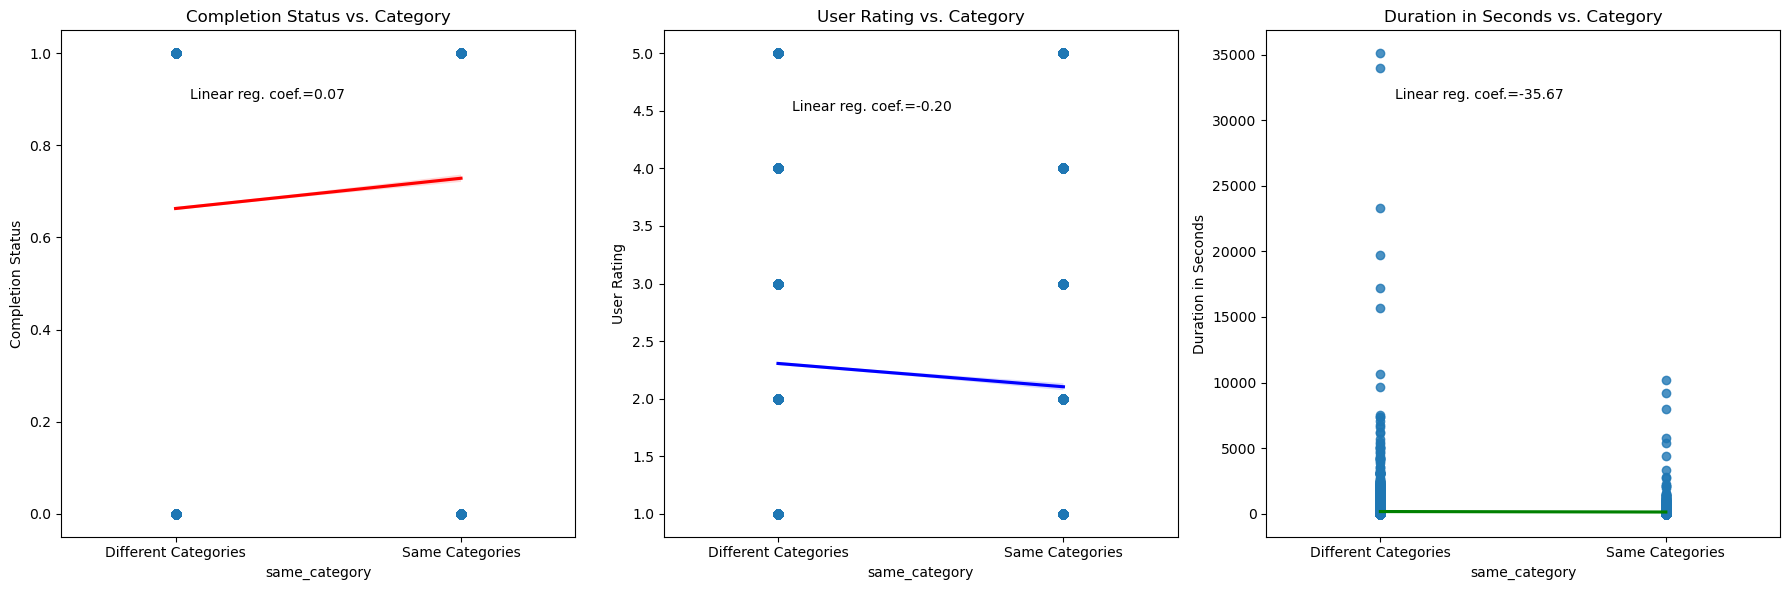

In [54]:

modelf = smf.ols(formula='finished ~ same_category', data=all_paths)
resultsf = modelf.fit()
modelr = smf.ols(formula='rating ~ same_category', data=all_paths)
resultsr = modelr.fit()
modeld = smf.ols(formula='durationInSec ~ same_category', data=all_paths[all_paths['finished'] == 1])
resultsd = modeld.fit()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Custom function to adjust x-axis
def set_xaxis_labels(ax):
    ax.set_xticks([0, 1])
    ax.set_xlim(left=-0.4, right=1.4)
    ax.set_xticklabels(['Different Categories', 'Same Categories'])

# Plot the first regression with confidence interval
sns.regplot(x='same_category', y='finished', data=all_paths, ax=axs[0], line_kws={'color': 'red'})
axs[0].set_title('Completion Status vs. Category')
axs[0].set_ylabel('Completion Status')
set_xaxis_labels(axs[0])

# Plot the second regression with confidence interval
sns.regplot(x='same_category', y='rating', data=all_paths, ax=axs[1], line_kws={'color': 'blue'})
axs[1].set_title('User Rating vs. Category')
axs[1].set_ylabel('User Rating')
set_xaxis_labels(axs[1])

# Plot the third regression with confidence interval
sns.regplot(x='same_category', y='durationInSec', data=all_paths[all_paths['finished'] == 1], ax=axs[2], line_kws={'color': 'green'})
axs[2].set_title('Duration in Seconds vs. Category')
axs[2].set_ylabel('Duration in Seconds')
set_xaxis_labels(axs[2])

# Calculate the coefficients
coef_finished = resultsf.params['same_category']
coef_rating = resultsr.params['same_category']
coef_duration = resultsd.params['same_category']

axs[0].text(x=0.05, y=max(filtered_paths['finished']) * 0.9, s=f'Linear reg. coef.={coef_finished:.2f}', color='black')
axs[1].text(x=0.05, y=max(filtered_paths['rating']) * 0.9, s=f'Linear reg. coef.={coef_rating:.2f}', color='black')
axs[2].text(x=0.05, y=max(filtered_paths[filtered_paths['finished'] == 1]['durationInSec']) * 0.9, s=f'Linear reg. coef.={coef_duration:.2f}', color='black')


plt.tight_layout()
plt.show()


In [83]:


def get_confidence_interval(result, x):
    predictions = result.get_prediction(pd.DataFrame({'same_category': x}))
    return predictions.conf_int()

x_values = np.array([0, 1])

fig = make_subplots(rows=1, cols=3, subplot_titles=('Completion Status vs. Category', 
                                                    'User Rating vs. Category', 
                                                    'Duration in Seconds vs. Category'))

# Plot for 'finished'
y_finished = resultsf.params['Intercept'] + resultsf.params['same_category'] * x_values
ci_finished = get_confidence_interval(resultsf, x_values)

fig.add_traces([
    go.Scatter(x=x_values, y=y_finished, mode='lines', name='Regression Line', line=dict(color='red')),
    go.Scatter(x=np.concatenate([x_values, x_values[::-1]]), y=np.concatenate([ci_finished[:, 0], ci_finished[:, 1][::-1]]), fill='toself', fillcolor='rgba(255, 0, 0, 0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False)
], rows=1, cols=1)

# Plot for 'rating'
y_rating = resultsr.params['Intercept'] + resultsr.params['same_category'] * x_values
ci_rating = get_confidence_interval(resultsr, x_values)

fig.add_traces([
    go.Scatter(x=x_values, y=y_rating, mode='lines', name='Regression Line', line=dict(color='blue')),
    go.Scatter(x=np.concatenate([x_values, x_values[::-1]]), y=np.concatenate([ci_rating[:, 0], ci_rating[:, 1][::-1]]), fill='toself', fillcolor='rgba(0, 0, 255, 0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False)
], rows=1, cols=2)

# Plot for 'durationInSec'
y_duration = resultsd.params['Intercept'] + resultsd.params['same_category'] * x_values
ci_duration = get_confidence_interval(resultsd, x_values)

fig.add_traces([
    go.Scatter(x=x_values, y=y_duration, mode='lines', name='Regression Line', line=dict(color='green')),
    go.Scatter(x=np.concatenate([x_values, x_values[::-1]]), y=np.concatenate([ci_duration[:, 0], ci_duration[:, 1][::-1]]), fill='toself', fillcolor='rgba(0, 255, 0, 0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False)
], rows=1, cols=3)


fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['Different<br>Categories', 'Same<br>Categories'],
    row=1, col=1
)
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['Different<br>Categories', 'Same<br>Categories'],
    row=1, col=2
)
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['Different<br>Categories', 'Same<br>Categories'],
    row=1, col=3
)
fig.update_yaxes(title_text="Unfinished - Finished", row=1, col=1)
fig.update_yaxes(title_text="Ratings (1-5)", row=1, col=2)
fig.update_yaxes(title_text="Finished game duration (sec)", row=1, col=3)


fig.update_layout(height=500, width=1200, title_text="Linear Regression Analysis", showlegend=False)

fig.show()




## How do different network centrality and clustering measures affect player paths and can it give us insight into the way humans perceive and utilize hubs in an information network?


In [203]:
del(edge_weights)

In [214]:
weighted_graph = nx.DiGraph()
edge_weights = {}

for _, row in filtered_paths[filtered_paths.finished == 0].iterrows():
    path = row['path']

    for i in range(len(path) - 1):
        source = path[i]
        target = path[i + 1]

        if not weighted_graph.has_edge(source, target):
            weighted_graph.add_edge(source, target, weight=1)
            edge_weights[(source, target)] = 1
        else:
            edge_weights[(source, target)] += 1
            weighted_graph[source][target]['weight'] = edge_weights[(source, target)]

num_nodes_weighted = len(weighted_graph.nodes)
num_edges_weighted = len(weighted_graph.edges)

print(f"Weighted Graph: {num_nodes_weighted} nodes, {num_edges_weighted} edges")


Weighted Graph: 3903 nodes, 23818 edges


In [215]:
num_nodes = weighted_graph.number_of_nodes()
num_edges = weighted_graph.number_of_edges()

weighted_avg_degree = sum(d for n, d in weighted_graph.degree(weight='weight')) / num_nodes if num_nodes > 0 else 0

graph_density = nx.density(weighted_graph)
avg_clustering_coef = nx.average_clustering(weighted_graph)

strongly_connected = nx.is_strongly_connected(weighted_graph)
weakly_connected = nx.is_weakly_connected(weighted_graph)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average weighted degree: {weighted_avg_degree}")
print(f"Graph density: {graph_density}")
print(f"Average clustering coefficient: {avg_clustering_coef}")
print(f"Strongly connected: {strongly_connected}")
print(f"Weakly connected: {weakly_connected}")


Number of nodes: 3903
Number of edges: 23818
Average weighted degree: 27.7996413015629
Graph density: 0.0015639377928607797
Average clustering coefficient: 0.1379902993623576
Strongly connected: False
Weakly connected: True


In [216]:
# Create an unweighted graph
unweighted_graph = weighted_graph.copy()
for u, v, data in unweighted_graph.edges(data=True):
    data['weight'] = 1  
unweighted_degree = dict(unweighted_graph.degree())

# Calculate the average unweighted degree
average_unweighted_degree = sum(unweighted_degree.values()) / len(unweighted_degree)

print(f"Average Unweighted Degree: {average_unweighted_degree}")


Average Unweighted Degree: 12.204970535485524


- Weighted degree >> unweighted: some articles are used as hubs?

In [217]:

degrees = dict(weighted_graph.degree(weighted_graph.nodes()))
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:200]
subgraph = unweighted_graph.subgraph(top_nodes)

layout = nx.spring_layout(subgraph)

#plt.figure(figsize=(12, 10))
#nx.draw(subgraph, pos=layout, with_labels=True, node_size=200, node_color='lightblue', font_size=10)
#plt.title("Top 100 Articles with Highest Degrees in Weighted Graph")
#plt.show()


In [218]:


degree_centrality = nx.degree_centrality(subgraph)
betweenness_centrality = nx.betweenness_centrality(subgraph)
closeness_centrality = nx.closeness_centrality(subgraph)
eigenvector_centrality = nx.eigenvector_centrality(subgraph)


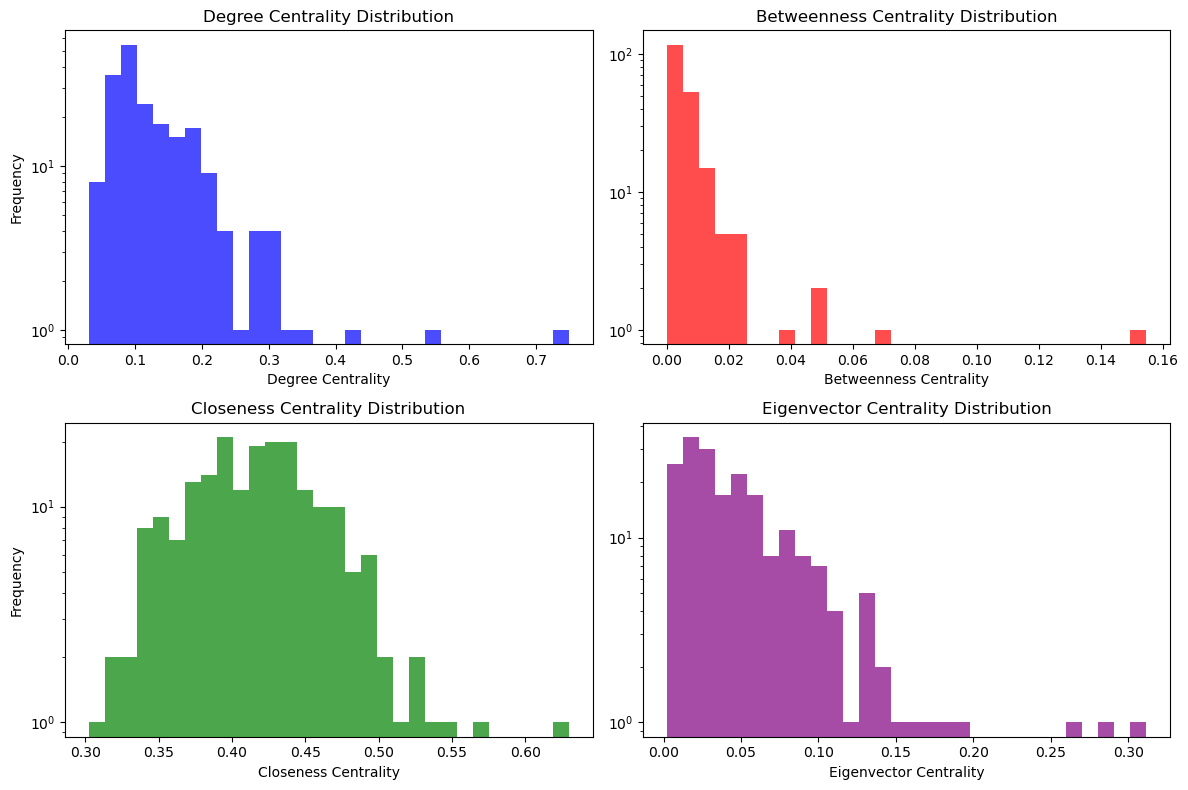

In [219]:
degree_centrality_values = list(degree_centrality.values())
betweenness_centrality_values = list(betweenness_centrality.values())
closeness_centrality_values = list(closeness_centrality.values())
eigenvector_centrality_values = list(eigenvector_centrality.values())

plt.figure(figsize=(12, 8))

# Degree distribution
plt.subplot(2, 2, 1)
plt.hist(degree_centrality_values, bins=30, color='blue', alpha=0.7, log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

# Betweenness distribution
plt.subplot(2, 2, 2)
plt.hist(betweenness_centrality_values, bins=30, color='red', alpha=0.7, log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness distribution
plt.subplot(2, 2, 3)
plt.hist(closeness_centrality_values, bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

# Eigenvector distribution
plt.subplot(2, 2, 4)
plt.hist(eigenvector_centrality_values, bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [163]:
mean_degree_centrality = np.mean(degree_centrality_values)
median_degree_centrality = np.median(degree_centrality_values)

mean_betweenness_centrality = np.mean(betweenness_centrality_values)
median_betweenness_centrality = np.median(betweenness_centrality_values)

mean_closeness_centrality = np.mean(closeness_centrality_values)
median_closeness_centrality = np.median(closeness_centrality_values)

mean_eigenvector_centrality = np.mean(eigenvector_centrality_values)
median_eigenvector_centrality = np.median(eigenvector_centrality_values)

print("Mean Degree Centrality:", mean_degree_centrality)
print("Median Degree Centrality:", median_degree_centrality)

print("Mean Betweenness Centrality:", mean_betweenness_centrality)
print("Median Betweenness Centrality:", median_betweenness_centrality)

print("Mean Closeness Centrality:", mean_closeness_centrality)
print("Median Closeness Centrality:", median_closeness_centrality)

print("Mean Eigenvector Centrality:", mean_eigenvector_centrality)
print("Median Eigenvector Centrality:", median_eigenvector_centrality)

Mean Degree Centrality: 0.1996482412060301
Median Degree Centrality: 0.1708542713567839
Mean Betweenness Centrality: 0.005914166793563779
Median Betweenness Centrality: 0.0036525631173030346
Mean Closeness Centrality: 0.4664186554753161
Median Closeness Centrality: 0.46604215456674475
Mean Eigenvector Centrality: 0.054112891113381995
Median Eigenvector Centrality: 0.041678591063635764


In [190]:


#all_degree_centrality = nx.degree_centrality(unweighted_graph)
#all_betweenness_centrality = nx.betweenness_centrality(unweighted_graph)
#all_closeness_centrality = nx.closeness_centrality(unweighted_graph)
#all_eigenvector_centrality = nx.eigenvector_centrality(unweighted_graph)
import pickle
with open('centrality_data.pkl', 'rb') as file:
    loaded_centrality_data = pickle.load(file)

all_degree_centrality = loaded_centrality_data['degree_centrality']
all_betweenness_centrality = loaded_centrality_data['betweenness_centrality']
all_closeness_centrality = loaded_centrality_data['closeness_centrality']
all_eigenvector_centrality = loaded_centrality_data['eigenvector_centrality']


In [170]:
mean_degree_centrality = np.mean(all_degree_centrality_values)
median_degree_centrality = np.median(all_degree_centrality_values)

mean_betweenness_centrality = np.mean(betweenness_centrality_values)
median_betweenness_centrality = np.median(betweenness_centrality_values)

mean_closeness_centrality = np.mean(closeness_centrality_values)
median_closeness_centrality = np.median(closeness_centrality_values)

mean_eigenvector_centrality = np.mean(eigenvector_centrality_values)
median_eigenvector_centrality = np.median(eigenvector_centrality_values)

print("Mean Degree Centrality:", mean_degree_centrality)
print("Median Degree Centrality:", median_degree_centrality)

print("Mean Betweenness Centrality:", mean_betweenness_centrality)
print("Median Betweenness Centrality:", median_betweenness_centrality)

print("Mean Closeness Centrality:", mean_closeness_centrality)
print("Median Closeness Centrality:", median_closeness_centrality)

print("Mean Eigenvector Centrality:", mean_eigenvector_centrality)
print("Median Eigenvector Centrality:", median_eigenvector_centrality)

Mean Degree Centrality: 0.005201127159897568
Median Degree Centrality: 0.0024067388688327317
Mean Betweenness Centrality: 0.005914166793563779
Median Betweenness Centrality: 0.0036525631173030346
Mean Closeness Centrality: 0.4664186554753161
Median Closeness Centrality: 0.46604215456674475
Mean Eigenvector Centrality: 0.054112891113381995
Median Eigenvector Centrality: 0.041678591063635764


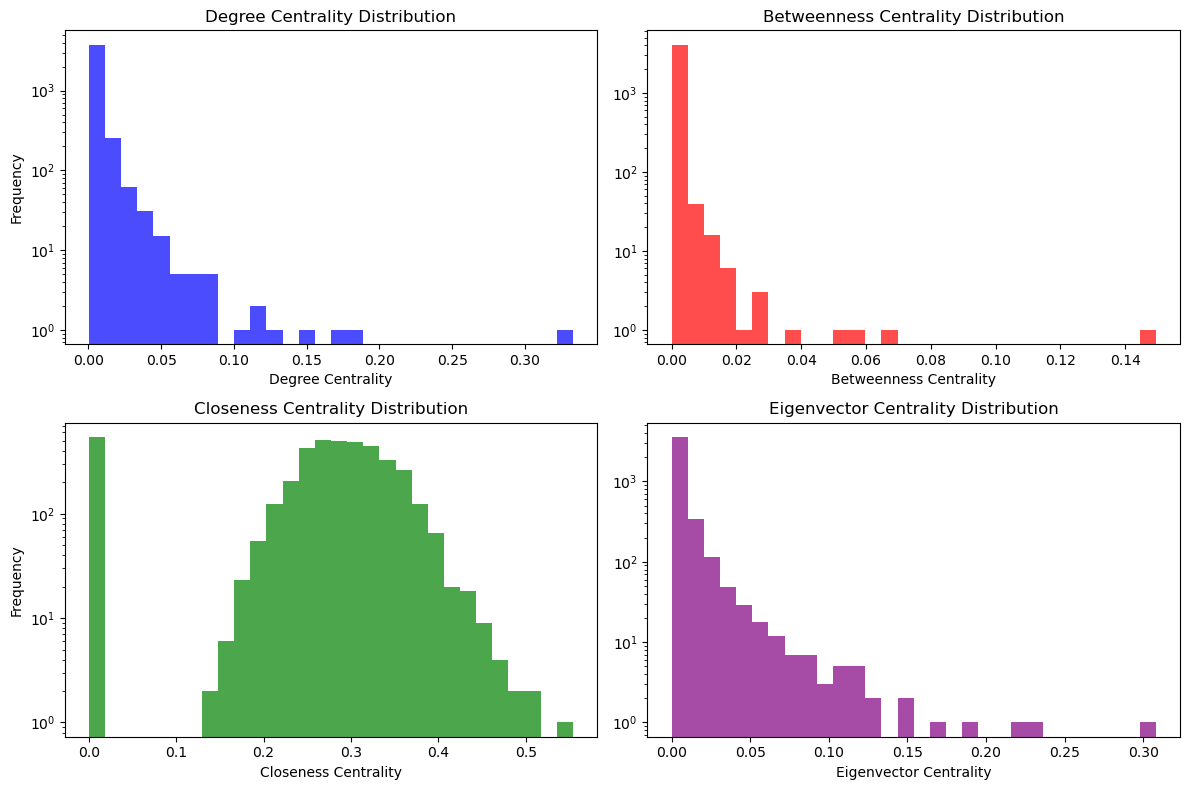

In [173]:
all_degree_centrality_values = list(all_degree_centrality.values())
all_betweenness_centrality_values = list(all_betweenness_centrality.values())
all_closeness_centrality_values = list(all_closeness_centrality.values())
all_eigenvector_centrality_values = list(all_eigenvector_centrality.values())

plt.figure(figsize=(12, 8))

# Degree distribution
plt.subplot(2, 2, 1)
plt.hist(all_degree_centrality_values, bins=30, color='blue', alpha=0.7, log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

# Betweenness distribution
plt.subplot(2, 2, 2)
plt.hist(all_betweenness_centrality_values, bins=30, color='red', alpha=0.7, log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness distribution
plt.subplot(2, 2, 3)
plt.hist(all_closeness_centrality_values, bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

# Eigenvector distribution
plt.subplot(2, 2, 4)
plt.hist(all_eigenvector_centrality_values, bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [220]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=['Degree Centrality Distribution', 'Betweenness Centrality Distribution', 'Closeness Centrality Distribution', 'Eigenvector Centrality Distribution'])

# Degree Centrality
fig.add_trace(go.Histogram(x=degree_centrality_values, nbinsx=30, name='Degree Centrality (top nodes)', marker_color='blue', opacity=0.4, histnorm='probability'), row=1, col=1)
fig.add_trace(go.Histogram(x=all_degree_centrality_values, nbinsx=30, name='Degree Centrality (overall)', marker_color='blue', opacity=0.7, histnorm='probability'), row=1, col=1)

# Betweenness Centrality
fig.add_trace(go.Histogram(x=betweenness_centrality_values, nbinsx=30, name='Betweenness Centrality (top nodes)', marker_color='red', opacity=0.4, histnorm='probability'), row=1, col=2)
fig.add_trace(go.Histogram(x=all_betweenness_centrality_values, nbinsx=30, name='Betweenness Centrality (overall)', marker_color='red', opacity=0.7, histnorm='probability'), row=1, col=2)

# Closeness Centrality
fig.add_trace(go.Histogram(x=closeness_centrality_values, nbinsx=30, name='Closeness Centrality (top nodes)', marker_color='green', opacity=0.4, histnorm='probability'), row=2, col=1)
fig.add_trace(go.Histogram(x=all_closeness_centrality_values, nbinsx=30, name='Closeness Centrality (overall)', marker_color='green', opacity=0.7, histnorm='probability'), row=2, col=1)

# Eigenvector Centrality
fig.add_trace(go.Histogram(x=eigenvector_centrality_values, nbinsx=30, name='Eigenvector Centrality (top nodes)', marker_color='purple', opacity=0.4, histnorm='probability'), row=2, col=2)
fig.add_trace(go.Histogram(x=all_eigenvector_centrality_values, nbinsx=30, name='Eigenvector Centrality (overall)', marker_color='purple', opacity=0.7, histnorm='probability'), row=2, col=2)

# Update layout
fig.update_layout(height=600, width=1000, showlegend=False,
                  title_text="Centrality Measures Distribution Comparison", barmode='overlay')
fig.update_xaxes(title_text='Centrality Value')
fig.update_yaxes(title_text='Normalized Frequency')

fig.show()


In [317]:

category_counts = categories.groupby('article')['category_1'].count()

# Calculate the average number of categories per article
average_categories_per_article = category_counts.mean()

print(f"Average number of categories per article: {average_categories_per_article:.2f}")


Average number of categories per article: 1.13


In [318]:
filtered_categories = categories[categories['article'].isin(top_nodes)]
category_counts = filtered_categories.groupby('article')['category_1'].count()
average_categories_per_top_nodes = category_counts.mean()

print(f"Average number of categories per article for top_nodes: {average_categories_per_top_nodes:.2f}")


Average number of categories per article for top_nodes: 1.28
